## Salary Prediction Using Various Machine Learning Algorithms 
#### Daniel Fridman, 2019

This notebook takes data from Kaggle's 2018 ML and DS Survey to develop mulitple regressors that can predict a data scientist's annual compensation. The dataset provided has been cleaned to an extent that it has 15429 responses with an outcome variable (annual compensation) recorded as a number for each observation. This notebook has six sections: Data cleaning, exploratory analysis, feature selection, model implementation, model tuning, and testing and discussion. 

We start off with getting the packages and data in order. 

In [1]:
%%capture
import time

starttime = time.time()
#Install them here
!pip install numpy  
!pip install pandas 
!pip install sklearn
!pip install matplotlib
!pip install seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import copy 
import re

from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, auc, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Get data in df
ksdat_orig= pd.read_csv(r'kaggle_salary.csv', sep=",", low_memory=False)
ksdat=copy.copy(ksdat_orig) #I've been burned so may times from python's objects just being references to an object. Also, I like keeping a clean set of the original data handy

#The first row in the DF is descriptors, not an observation. Let's store the info in a list and drop the row 
qtext=pd.DataFrame(ksdat.loc[0])
ksdat.drop(0, inplace=True)
qtext.drop('Unnamed: 0', inplace=True)

#Drop some other useless rows
ksdat.drop(['Unnamed: 0','index'], axis=1, inplace=True)

#Rename time column for convenience
ksdat.rename(columns={ksdat.columns[0]:'time'}, inplace=True)

### Part 1: Data cleaning

We have our data loaded into a Pandas DF. Let's get started!

So far, I know very little about the dataset. I've read through the questions and that's about it. We're looking to model 'data scientist' salary, so let's what these 'data scientist' positions are.

In [3]:
ksdat['Q9']=ksdat['Q9'].astype('int')
tab=ksdat.groupby(['Q6']).agg({'Q9': ['mean', 'std', np.median]})
tab.columns = tab.columns.get_level_values(1)
tab.reset_index(level=0, inplace=True)
tab=tab.sort_values(by=['mean'])
tab.head(5)

,Q6,mean,std,median
19,Student,12251.679389,27065.246789,6429.5
14,Research Assistant,24307.552573,38718.170841,14925.0
4,Data Analyst,42409.284314,47993.000105,29356.0
8,Developer Advocate,46428.588235,47930.385686,32306.0
0,Business Analyst,47487.520339,52134.500734,37299.0


This dataset contains ~2600 students with a mean salary of ~$12,500. This category seems like an outlier and I'm really not interested in how much students make. Not many people go to school because they think 'student' is a job or that they will make a lot of money being a student. I'm going to remove these from the dataset. I also suspect that student may respond in ways that are systematically different than those who are employed may dilute the signals. I would have to conduct a whole other analysis to prove this, but I'm not worried about it at the moment, and ~13K remaining observations should be enough.  

Also, Q7 asks about what industry people are in and there are some respondents that list 'I am a student,' while listing their title as something other than student. It's about ~280ish people. I'm gonna get rid of these too!

In [4]:
ksdat = ksdat.drop(ksdat[ksdat["Q6"] == 'Student'].index)
ksdat = ksdat.drop(ksdat[ksdat["Q7"] == 'I am a student'].index)
len(ksdat)

12364

With our dataset restricted to the observations in which we are interested, let's look at the data and prepare it for analysis (clean). If we take a quick look at the data we notice that the text columns do not seem to have any useful information. The contest website suggests that these responses are anonymized and available in another dataset. So, let's get rid of them.

In [5]:
textCols = [col for col in ksdat.columns if 'TEXT' in col]
ksdat=ksdat.drop(textCols, axis=1)

Down to 363 columns. That should make things about 9% easier!

Now let's deal with the categorical data. This dataset is chock full of multi-select items where each item has its own column. The values act as an indicator (if it is selected it takes a value, otherwise it is NaN. That is good, becasue we can identify these columns by the number of the uniqe values they have (2). Also, the label can be generated from the list of descriptions we captured. So, our next step is to recode thses variables. We do this with boolean coding. 


In [6]:
#Get a list of the binary variables
unq_labs=ksdat.columns
unq_len=[]

for column in ksdat:
    unq_len.append(len(ksdat[column].unique()))

unq_df = pd.DataFrame(
    {'colname': unq_labs,
    'uniques': unq_len})

novar=list(unq_df[unq_df['uniques']==1]['colname'])
binvar=list(unq_df[unq_df['uniques']==2]['colname'])
multivar=list(unq_df[unq_df['uniques']>2]['colname'])
#Drop rows with only one unique value (no variation)
ksdat=ksdat.drop(novar, axis=1)

##Now we replace the missing values with 0's...
ksdat[binvar] = ksdat[binvar].fillna(value=0)
ksdat[binvar] = ksdat[binvar].astype(bool)
ksdat[binvar] = ksdat[binvar].astype(int)

ksdat[binvar].head(2)

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q49_Part_11,Q49_Part_12,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


That takes care of 314 columns! Now we look at the remaining columns with missing data. 

In [7]:
#While we're at it, we can get a table of all the rest of the variables and how many unique responses each has (this may be useful later... or not?)
unq_df_gt2=unq_df[unq_df['uniques']>2]
unq_df_gt2.set_index('colname', inplace=True)
unq_df_gt2['missing']=ksdat[multivar].isna().sum()
unq_df_gt2=unq_df_gt2.join(qtext)
unq_df_gt2


,uniques,missing,0
colname,,,
time,4724,0,NaN
Q1,4,0,What is your gender? - Selected Choice
Q2,12,0,What is your age (# years)?
Q3,58,0,In which country do you currently reside?
Q4,7,0,What is the highest level of formal education ...
Q5,14,120,Which best describes your undergraduate major?...
Q6,19,0,Select the title most similar to your current ...
Q7,18,0,In what industry is your current employer/cont...
Q8,12,8,How many years of experience do you have in yo...


Dealing with missingness, our first consideration is what missing data do we want to keep (for recoding) and what do we want to get rid of?

Thinking about missingingness in survey data, I think many respondents who did not complete a given question either felt that the question was not relevant to them or what they do (i.e. If you did not do an undergraduate degree, how would you describe your undergraduate major?). Given this, non-response may be considered a response in itself. Indeed, we take this approach in recoding missingness for most variables, coding missing values as "No Answer". If too many respondents failed to answer a particlular question, we exlude it due to the resulting lack in variation. This action has to be balanced with our apriori assumption about how the responses to that question will be related to the output. If our apriori assumption about the explanatory power of a question is significantly high, we may drop observations that are missing it. This also requires the assumption that the data is missing at random. In doing so, we are assuming that dropping these observations will not intrduce bias into our prediction since we are assuming that their missingness is not related to the outcome variable. Finally, for some approaches with a few missing, but not deemed interesting enough to exclude the whole observation, we can impute the value. For categorical variables, we use a proportionally random assignment to preserve the overall distribution of responses.     

Enough chit-chat, let's get to it:

We get rid of Q37 since it has too much missingness to be useful (also, we have made the apriori assumption that the content of the question relatively unimportant)

Also, Q32_OTHER and Q47_Part_16 are text columns that didn't get caught by our previous filter.

Q34 and Q35 (time allocation on data science projects/training) seems extremely important. We'll drop any observations who did not respond. 

We're going to code the following (multiple choice) columns with 'No Answer':
Q5, Q17, Q32, Q39, Q41, Q43, Q46, Q48

We're also going to conditionally recode Q20 and 22 if they answered 'None' in the previous question. 

If, after all of that, there are still some missing values in 8, 20 and 22, we'll use random categorical assignment for 8 and add an 'Not Answered" option to 20 and 22.

In [8]:
miss_drop_col=['Q32_OTHER', 'Q47_Part_16', 'Q37']
ksdat=ksdat.drop(miss_drop_col, axis=1)
unq_df_gt2=unq_df_gt2.drop(miss_drop_col, axis=0)

ksdat = ksdat.drop(ksdat[ksdat["Q34_Part_1"].isna()==True].index)
ksdat = ksdat.drop(ksdat[ksdat["Q35_Part_1"].isna()==True].index)

##Make sure the answers to 34 and 35 add up to 100, rescal those that don't and drop any that are all 0's 
def scalecols(df, lst):

    df[lst]=df[lst].astype(float)
    df['scale']=100/df[lst].sum(axis=1)
    df=df.replace([np.inf, -np.inf], np.nan)
    
    for col in lst:
        df[col]=df[col]*df['scale']
    
    df=df.drop('scale', axis=1)
    return(df.loc[(df[lst].sum(axis=1) != 0), :]) 

q34=["Q34_Part_1", "Q34_Part_2", "Q34_Part_3", "Q34_Part_4", "Q34_Part_5", "Q34_Part_6"]
q35=["Q35_Part_1", "Q35_Part_2", "Q35_Part_3", "Q35_Part_4", "Q35_Part_5", "Q35_Part_6"]

ksdat=scalecols(ksdat,q34)
ksdat=scalecols(ksdat,q35)

In [9]:
fill_miss_cols=['Q5', 'Q17', 'Q32', 'Q39_Part_1','Q39_Part_2', 'Q40', 'Q41_Part_1', 'Q41_Part_2', 'Q41_Part_3', 'Q43', 'Q46', 'Q48']

ksdat[fill_miss_cols] = ksdat[fill_miss_cols].fillna(value="No Answer")

In [10]:
def cond_recode_miss(df, col1, val1, col2, val2):
    for index, row in df.iterrows():
        if (row[col1]==val1) and (pd.isnull(row[col2])):
            df.set_value(index,col2,val2)
            
cond_recode_miss(ksdat, 'Q19_Part_18', 1, 'Q20', 'None')
cond_recode_miss(ksdat, 'Q21_Part_12', 1, 'Q22', 'None')

fill_miss_cols=['Q20', 'Q22']
ksdat[fill_miss_cols] = ksdat[fill_miss_cols].fillna(value="No Answer")

In [11]:
import random
r=len(ksdat.index)
for index, row in ksdat.iterrows():
    if pd.isnull(row['Q8']):
        j=random.randint(0,r)
        val=ksdat.iloc[j]['Q8']
        ksdat.set_value(index, 'Q8', val)
        
print('Total missing values in the df:', ksdat.isnull().sum().sum())

Total missing values in the df: 0


OK. No missing values. Now let's look and see if we should recode some categorical variables. Of the bat, there are two variables that seem ripe for recoding: age, experience and education. Age and experience because they could be continuous. We are going to take a simple approach: replace each value with the mean of the category. We could randomly assign values from within the reported age-range, but I see no advantage of this approach. 

In [12]:
#Get a list of the binary variables
unq_labs=ksdat.columns
unq_len=[]

for column in ksdat:
    unq_len.append(len(ksdat[column].unique()))

unq_df = pd.DataFrame(
    {'colname': unq_labs,
    'uniques': unq_len})

#Create list of categorical and continusous variables, inspection of the data has confirmed these rules: catvars have 2>uniques>31, otherwise it's continuous. 
unq_df.set_index('colname', inplace=True)
unq_df.join(qtext)

catvar=list(unq_df[unq_df['uniques']>2].index)
contvar=list(unq_df[unq_df['uniques']>30].index)

catvar=[i for i in catvar if i not in contvar]

#The rule has one exception (country)
catvar.append(contvar.pop(contvar.index('Q3')))

print('bin:',len(binvar),'\ncont:', len(contvar), '\ncat:', len(catvar))
print('Total:', len(binvar)+len(contvar)+len(catvar), '\n# of columns (check):', len(ksdat.columns))

bin: 314 
cont: 14 
cat: 28
Total: 356 
# of columns (check): 356


In [13]:
q2dict={'30-34':32, '22-24':23, '35-39':37, '18-21':19.5, '40-44':42, '25-29':27, '55-59':57,'60-69':64.5,'45-49':47, '50-54':52, '70-79':74.5, '80+':81} #This is arbitrary, but.... 11 observations, anything we put here would be arbitrary
q8dict={'0-1':0.5, '10-15':12.5,'3-4':3.5, '5-10':7.5, '1-2':1.5, '2-3':2.5, '4-5':4.5, '15-20':17.5, '25-30':27.5, '20-25':22.5, '30 +':32} #Again, same prob
q24dict={'1-2 years':1.5, '3-5 years':4, '< 1 year':0.5, '5-10 years':7.5, '10-20 years':15, '20-30 years':25, '30-40 years':35, '40+ years':41}
q25dict={'1-2 years':1.5, '< 1 year':0.5, '2-3 years':2.5, '3-4 years':3.5, '5-10 years':7.5, '4-5 years':4.5, 'I have never studied machine learning but plan to learn in the future':0, '10-15 years':12.5, '20+ years':21, 'I have never studied machine learning and I do not plan to':0}

ksdat['Q2']=ksdat['Q2'].map(q2dict)
ksdat['Q8']=ksdat['Q8'].map(q8dict)
ksdat['Q24']=ksdat['Q24'].map(q24dict)
ksdat['Q25']=ksdat['Q25'].map(q25dict)

contvar.append(catvar.pop(catvar.index('Q2')))
contvar.append(catvar.pop(catvar.index('Q8')))
contvar.append(catvar.pop(catvar.index('Q24')))
contvar.append(catvar.pop(catvar.index('Q25')))

Finally, we recode that categorical variables as dummies. Though technically we only need k-1 dummies for k categories, we're going to keep k because we don't really know what we want our baseline to be for each one and for this exercise, it is not interested to define.  

In [14]:
#Create a df of dummies from the catvars
dummies=pd.DataFrame(index=ksdat.index)
for var in catvar:
    dummies=dummies.join(pd.get_dummies(ksdat[var], prefix=var))

#Create a the final, clean df
df=ksdat.drop(catvar, axis=1)
df=df.join(dummies)

#check that all values are numerical
print('Total columns:', df.dtypes.value_counts().sum())
print('Columns by dtype: \n', df.dtypes.value_counts())
print('Expose the aberations!!!!: ', df.select_dtypes(include='object').columns)

Total columns: 619
Columns by dtype: 
 int64      315
uint8      287
float64     16
object       1
dtype: int64
Expose the aberations!!!!:  Index(['time'], dtype='object')


In [15]:
#I will make time will bend the knee!!!
df['time']=df['time'].astype('int')
print('Columns by dtype: \n', df.dtypes.value_counts())

#for good measure, let's just reset the index because it's nicer that way
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df.head(10)
print('Total observations in set: ',len(df))

Columns by dtype: 
 int64      315
uint8      287
float64     16
int32        1
dtype: int64
Total observations in set:  9434


And in the end, we have a df with all no missing values and all numerical values.... pretty clean! 
One last thing: All the (now) binary variables have coded labes (i.e. Q11_Part_2). Let's change "Part_2" to the actual option value. 

In [16]:
qtext.rename(columns={0:'long'}, inplace=True)
qtext['short']=qtext['long'].str.split(' - ')
qtext['ind']=qtext.index.str.split('_')

for index, row in qtext.iterrows():
    if isinstance(row['short'], (list,)):
        q=row['ind'][0]
        opt=row['short'][-1]
        val=q+"_"+opt
        #print(val)
        qtext.at[index, 'lab']= val

qtextT=qtext.T
bindict=qtextT[binvar].loc['lab'].to_dict()
binvarRe=qtextT[binvar].loc['lab'].to_list()
df.rename(columns=bindict, inplace=True)
df[binvarRe].head(3)

,Q11_Analyze and understand data to influence product or business decisions,Q11_Build and/or run a machine learning service that operationally improves my product or workflows,"Q11_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q11_Build prototypes to explore applying machine learning to new areas,Q11_Do research that advances the state of the art of machine learning,Q11_None of these activities are an important part of my role at work,Q11_Other,Q13_Jupyter/IPython,Q13_RStudio,Q13_PyCharm,...,Q49_None/I do not make my work easy for others to reproduce,Q49_Other,Q50_Too expensive,Q50_Too time-consuming,Q50_Requires too much technical knowledge,Q50_Afraid that others will use my work without giving proper credit,Q50_Not enough incentives to share my work,Q50_I had never considered making my work easier for others to reproduce,Q50_None of these reasons apply to me,Q50_Other
0,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,1,0,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,0


### Part 2 - Exploratory analysis

For our exploratory analysis we are going to be looking at the at the variables that we recoded to be continuous. We are going to plot them against mean and meadian salary as well as the std dev. This will give us some insight about the relationship.

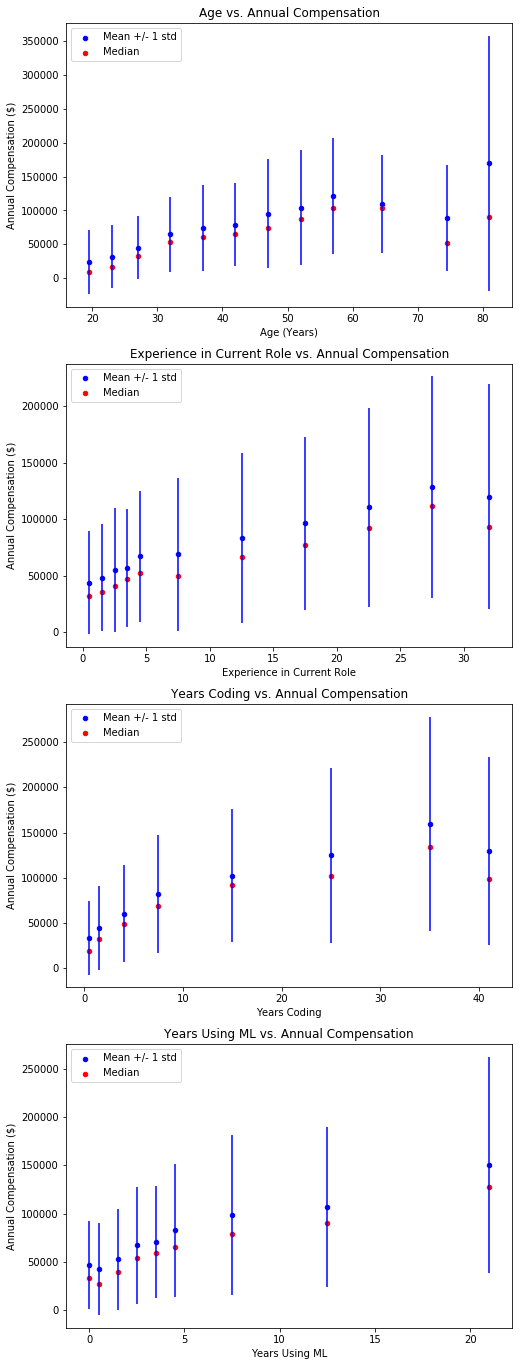

In [17]:
import matplotlib.pyplot as plt

fig1, (ax1, ax2, ax3, ax4)=plt.subplots(nrows=4, ncols=1)

def plt_cont(x, xlab, title, ax):
    plt=df.groupby([x]).agg({'Q9': ['mean', 'std', np.median]})

    plt.columns = plt.columns.get_level_values(1)
    plt.reset_index(level=0, inplace=True)

    plt.plot(kind='scatter', x=x, y='mean', yerr='std', ax=ax, color='blue', title=title)
    plt.plot(kind='scatter', x=x, y='median', ax=ax, color='red')
    ax.legend(["Mean +/- 1 std", "Median"], loc=2)
    ax.set_xlabel(xlab)
    ax.set_ylabel("Annual Compensation ($)")

plt_cont('Q2', 'Age (Years)', 'Age vs. Annual Compensation', ax1)
plt_cont('Q8', 'Experience in Current Role', 'Experience in Current Role vs. Annual Compensation', ax2)    
plt_cont('Q24', 'Years Coding', 'Years Coding vs. Annual Compensation', ax3)
plt_cont('Q25', 'Years Using ML', 'Years Using ML vs. Annual Compensation', ax4)

fig1.set_size_inches(8, 24)

Well, it seems everything is positively skewed, where the mean is higher than the median (it is being pulled up by some very large salaries). Also, we see a lot of variation. We do see some interesting things that may help us model/predict salaries. While the relationships are mostly linear, we can see som nonlinearities. We address these by creating indicator variables at the different 'kinks' in the line. This is like a splines approach in linear regression. 

For Q2 we'll create an indicator for >57, and >75.
For Q8 we create one for >28
For Q24 we create one for >35
For Q25 we create one for >5, >15

In [18]:
def code_knot(x,y):
    z=0
    if x>y:
        z=1
    return(z)
vcode_knot=np.vectorize(code_knot)

df['Q2gt57']=vcode_knot(df['Q2'],57) 
df['Q2gt75']=vcode_knot(df['Q2'],75) 
df['Q8gt28']=vcode_knot(df['Q8'],28) 
df['Q24gt35']=vcode_knot(df['Q24'],35) 
df['Q25gt5']=vcode_knot(df['Q25'],5) 
df['Q25gt15']=vcode_knot(df['Q25'],15) 

We now turn out attention to correlation. We calculate the pearson correlation coefficient to see which items in our dataset are most linearly correlated with the outcome and in what direction. Values closer to +/-1 indicate stronger correlation. The sign indicates the direction of the correlation, >0 -> positive, <0 -> negative. 

In [19]:
cor9=df.corr()['Q9'].sort_values(ascending=False)
cor9.drop('Q9', inplace=True)

Top 10 Positively Correlated Variables:
 Q3_United States of America                                                                   0.462002
Q24                                                                                           0.379722
Q2                                                                                            0.356319
Q25                                                                                           0.314138
Q8                                                                                            0.290399
Q25gt5                                                                                        0.257993
Q15_Amazon Web Services (AWS)                                                                 0.193353
Q27_AWS Elastic Compute Cloud (EC2)                                                           0.192798
Q10_We have well established ML methods (i.e., models in production for more than 2 years)    0.192414
Q11_Build prototypes to explore 

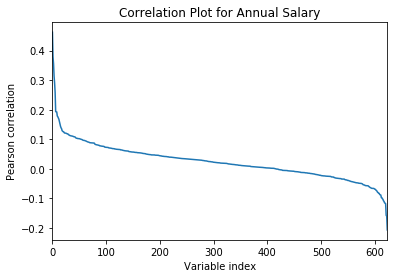

In [20]:
fig2, axcorr=plt.subplots(nrows=1, ncols=1)
cor9.plot(use_index=False, title="Correlation Plot for Annual Salary", ax=axcorr)
axcorr.set_ylabel("Pearson correlation")
axcorr.set_xlabel("Variable index")
print('Top 10 Positively Correlated Variables:\n', cor9.head(10))
print('\n\nTop 10 Negatively Correlated Variables (reverse order):\n', cor9.tail(10))

Unsurprisingly the four plotted continuos(ly coded) variables are among the top correlated ones.  The vast majority of covariates are not very correlated with the outcome. This does not bode well for our prediction effort, especially for linear methods. I bet if we use LASSO for variable selection, we will significantly reduce the feature space. Speacking of feature selection, ONTO PATR 3!

### Part 3 Feature Selection

Data is to data science as fuel is to cars. You could build a vehicle to run on crude oil, but it would run better on refined fuel. Similarly, we can feed in crude data to the ML algorithms, or we can try and refine the data and strneghten the predictive signal. We can do this manually, (as we did with the knots in part 2. Or we can do this algorithmically with tools like LASSO, which minimizes the the typical sum of squares loss function PLUS penalty terms on the sum of the absolute value of the coefficients (the L1 norm). Thus, as the wieght of the penalty increases, many coefficients are driven to 0. This weight (lambda) can be tuned. We use scikit-learn's lassoCV, which has built-in CV for tuning (we use k=10). Then we use the non-zero features. 

A major drawback of this approach is that we are selecting features solely on the basis of their linear relationships with the data. But, this is a learning exercise and I've already sepnt 3 days on this up to this point, so on with it!

We could have used some dimension reduction algo like PCA, but I think we have too many sparse binary variables for it to be good. Also, a method that focuses on variation within the X's is probably not that useful good for this exercise, in which we are interested in the relationship between the X's and variation in the Y's. Then there is LDA, but I don't think I want to treat the Y's as labels (that would be insane!)   

One bit of manual feature selection though, I'm going to drop 'time.' I'm not interested in any 'meta' responses, just the regular ones. 

To avoid the problem of leakage, this is the point where we separate our training and testing datasets. 

In [21]:
from sklearn.model_selection import train_test_split
X=df.drop(['time','Q9'], axis=1)
y=df['Q9']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [22]:
reg = LassoCV(cv=10, random_state=0).fit(X_train, y_train)

In [23]:
print('R-squared:\nTrain:',reg.score(X_train, y_train))
print('Test:',reg.score(X_test, y_test))

coeffs = pd.DataFrame(reg.coef_, index = X_train.columns)
varSel=coeffs[coeffs[0].abs()>0]

varSel.sort_values(by=0, ascending=False)
selected=varSel.index.tolist()

varlist=list(X_train.columns)
droplist=[x for x in varlist if x not in selected ]

print("Lasso picked ", len(varlist)-len(droplist)," variables and eliminated the other ", len(droplist), " variables")
X_train.drop(droplist, axis=1, inplace=True) 
X_test.drop(droplist, axis=1, inplace=True)

R-squared:
Train: 0.48256084569665647
Test: 0.4929887287626726
Lasso picked  169  variables and eliminated the other  454  variables


OK! Now we've gotten rig of 458 columns. We've got our 164 variables, onward!

### Model implementation and Tuning
We've algorithmically picked our covariates, no let's run some models. We are going to run four models, choosing them on the basis of variety of approach. LASSO, CART, Random Forrest and Boosted trees (with adaboost).

LASSO: Explained above, we used it to select features. It does this by penalizing the slope of the least squares hypeplane by adding the l1 norm of the slope (mulitplied by a hyperparameter lambda) to the sum of squares minimization. This forces the least informative covariates to have coefficients of 0 (the more the penalty the higher the threshold for having a non-zero coefficient.  We did it above with CV, but 1) I'm curious what happens when we do it again on the restricted dataset, and 2) we'll be more explicit baout the CV and grid search. 

CART: Simple trees. It builds one tree by finding the best splits to create two 'purer' leaves. 

Random Forrest: This is an example of a bagged approach, which stands for bootstrapped aggregated. Many trees are grown using bootstrapped samples of the covariates (a subset of the columns of X). In the end, many full-grown trees are grown and they vote on the outcome. All trees have an equally-weighted vote. We can tweak hyperparameters such as how many trees are grown, or the size of the sample of covariates used. 

Boosted trees (with adaboost): Boosted trees is also an approach that grows many trees, but it's more like many shrubs. They grow many weak learners (not fully grown, often just one level). Weak learners are grown iteratively. With adaboost the best performaing tree is kept and subsequent weak learners are grown which privilege learning the incorrectly classified observations (this is the boosting). This continues and finally the weak learners cast their vote, which is weighted by how well they performed. 

We compare these methods on the basis an R-squared measure which measures the portion of variation explained by the model. I don't expect very high scores since the process for making the outcome variable a continuous variable from a categorical one introduced a fair bit of randomness (noise). 

I'm combining model implementation and tuning because I don't want to rerun all the models for no reason. So let's tune and 'impelment' in one go and I'll answer all the CV questions based on the top-performing configuration of each. 

Let's get into it. 

In [24]:
from sklearn import linear_model

# Compare parameters by score of model 
acc_scorer= make_scorer(r2_score)

reg_gridsearch = linear_model.Lasso(random_state=0, max_iter=1000, tol=1)

params = {'alpha':[0.5,1,5], 'normalize':[True,False]} 

grid_lasso = GridSearchCV(reg_gridsearch, params, cv=10, scoring=acc_scorer,return_train_score=True)
grlasso  = grid_lasso.fit(X_train, y_train)

lasso_best = grlasso.best_estimator_  

#print(run_kfold(reg))
print('alpha (Constant that multiplies the L1 term):',grlasso.best_estimator_.alpha) 
print('normalize:',grlasso.best_estimator_.normalize)

alpha (Constant that multiplies the L1 term): 5
normalize: True


In [25]:
predictions_lasso=lasso_best.predict(X_test)
cv_res1=pd.DataFrame(grlasso.cv_results_).iloc[grlasso.best_index_]
lasso_best.score(X_test, y_test)

0.4833357044648977

Onto the CART where we are going to play with the max_dpeth and min_split hyper parameters. Increasing max depth should decrease bias as with more dpeth, we can more specifially separate the values. Increasing the min split should decrease bias since it will limit the how specifically we can keep separating values. Obviously if we increase/decrease bia, we have the opposite effect on variance. 

In [26]:
from sklearn import tree
cart_gridsearch = tree.DecisionTreeRegressor(random_state=0)

params = {'max_depth':[None,2,10,50], 'min_samples_split':[2, 20, 100, 1000]} 

# Compare parameters by score of model 
#acc_scorer= make_scorer(r2_score)

grid_cart = GridSearchCV(cart_gridsearch, params, cv=10, scoring=acc_scorer, return_train_score=True)
grcart  = grid_cart.fit(X_train, y_train)

cart_best = grcart.best_estimator_  

In [27]:
predictions_cart=cart_best.predict(X_test)
cv_res2=pd.DataFrame(grcart.cv_results_).iloc[grcart.best_index_]
cart_best.score(X_test, y_test)

0.3541142589029468

Onto random forest where we take some learning from our CART experience and use min_split of 100 and max_depth of 10 (there are so mayny hyper parameters, has an exponential effect on run-time and... no). Anyway, the interesting thing about this one is that it is suggested by Breiman (2001) that his propposed bagging method will reduce both bias and variance. No wonder an RF model won the 2006 Netflix prize! I believe the idea is that the bootstrapping prevents any single covariate from dominating the prediction (decreasing bias) while the aggregating combines more information than would otherwise be available thus, reducing the variance. There are no proofs to show this, but a tonne of simulation studies. Anyway, people love random forests. Let's vary the sample size of the covariates and the number of trees in the forest. A con for this one is that it can have a serious runtime, depending on the hyperparameters.  

In [28]:
from sklearn.ensemble import RandomForestRegressor
rf_gridsearch = RandomForestRegressor(max_depth=10,  min_samples_split=100, random_state=0)

params = {'n_estimators':[10, 100, 1000], 'max_features':[5, 10, 100]} 

grid_rf = GridSearchCV(rf_gridsearch, params, cv=10, scoring=acc_scorer,return_train_score=True)
grrf  = grid_rf.fit(X_train, y_train)

rf_best = grrf.best_estimator_  

In [29]:
predictions_rf=rf_best.predict(X_test)
cv_res3=pd.DataFrame(grrf.cv_results_).iloc[grrf.best_index_]
rf_best.score(X_test, y_test)

0.4516984464749243

Finally, the boosted trees with Adaboost. Here we are again using some info from our previous mnodels because we don't have all day to wait for it to churn out models for too many different combinations (three values for one parameter already takes about 10 min to go through). We choose to set a max depth at 4. If there are a lot of interaction effects from the covariates, I would expect this model to do poorly since weak learners can only classify based on a couple splits.    

In [30]:
from sklearn.ensemble import AdaBoostRegressor

ada_gridsearch = AdaBoostRegressor(tree.DecisionTreeRegressor(max_depth=4), random_state=0)

params = {'n_estimators':[10, 100, 1000]} 

# Compare parameters by score of model 
acc_scorer= make_scorer(r2_score)

grid_ada = GridSearchCV(ada_gridsearch, params, cv=10, scoring=acc_scorer,return_train_score=True)
grada  = grid_ada.fit(X_train, y_train)

ada_best = grada.best_estimator_  

In [31]:
predictions_ada=ada_best.predict(X_test)
cv_res4=pd.DataFrame(grada.cv_results_).iloc[grada.best_index_]
ada_best.score(X_test, y_test)

0.15796103479786516

Now let's see the results from the best model fits. 

In [32]:
resdict={'LASSO':cv_res1, 'CART':cv_res2, 'RF':cv_res3, 'adaTree':cv_res4}
resdf=pd.DataFrame(resdict)
print(resdf.head(10))
print(resdf.tail(2))

                              LASSO        CART        RF    adaTree
mean_fit_time             0.0388903   0.0860034   28.2759   0.478125
mean_score_time          0.00199947  0.00179973  0.085452  0.0033006
mean_test_score            0.456482    0.360604  0.443662   0.139849
mean_train_score           0.481368    0.498787  0.531725   0.279416
param_alpha                       5         NaN       NaN        NaN
param_max_depth                 NaN          10       NaN        NaN
param_max_features              NaN         NaN       100        NaN
param_min_samples_split         NaN         100       NaN        NaN
param_n_estimators              NaN         NaN      1000         10
param_normalize                True         NaN       NaN        NaN
                      LASSO        CART          RF    adaTree
std_test_score    0.0818087   0.0887809   0.0655385  0.0576431
std_train_score  0.00767737  0.00526529  0.00705462  0.0301275


Based on the mean R-sqared value across folds, the best model was the LASSO (alpha=5, normalize=True). It was also fastest. Of course, we have to consider that we chose our variables based on LASSO (which is probably why the highest penalty won out), so maybe it wasn't a fair fight, but... meh? LASSO was also the fastest algo. 

Let's look at the bias-variance trade-off: Overall the LASSO had the least bias as the mean training and testing scores were the closest of any of the algos. CART and RF seems to overfit the data as they each had (marginally) higher training scores, but lower testing scores. Adaboost (as expected) sucked (relatively) in both categories. 

Let's see how they each did across the folds:

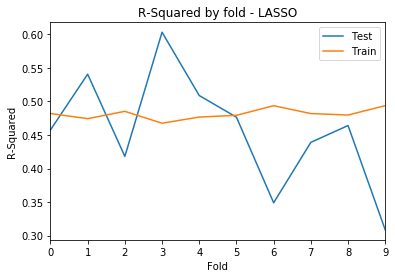

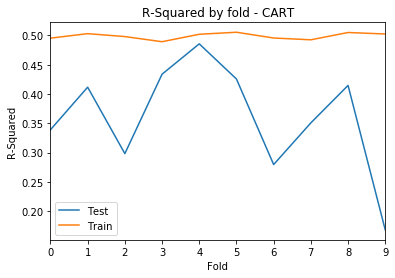

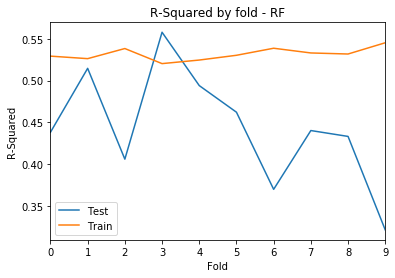

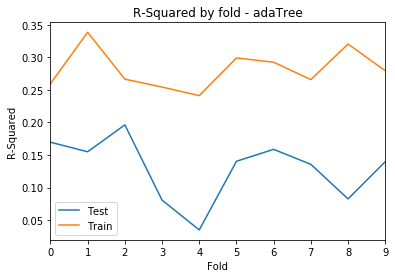

In [33]:
for model in resdict.keys():
    ax=plt.gca()
    trainerr=resdict[model].iloc[20:30].reset_index().iloc[:,1]
    testerr=resdict[model].iloc[7:17].reset_index().iloc[:,1]
    pltdf=pd.DataFrame({'Test':testerr, 'Train':trainerr})
    pltdf.plot(kind='line', title="R-Squared by fold - " +model, ax=ax)
    ax.set_xlabel('Fold')
    ax.set_ylabel('R-Squared')
    plt.show()

Overall, most methods suffered from consistent overfittering (predicted the training set better than the test set), but not LASSO. I guess there are some pretty strong linear trends. Let's take our best model and do some predictions.

### Predictions and discussion

In [34]:
train_score=lasso_best.score(X_train, y_train)
test_score=lasso_best.score(X_test, y_test)

print('R-Squared for predicting training set ', train_score)
print('R-Squared for predicting test set ', test_score)

R-Squared for predicting training set  0.47986725411087405
R-Squared for predicting test set  0.4833357044648977


Overall, it did not bad. The model accounts for almost half of the variation in the data and does so pretty consistently on test and training sets (no over-fitting). I'm actually pretty impressed considering how much noise in the outcome variable is introduced from the random assignment of integers from a category. To improve accuracy, I would do a deeper dive into feature selection/engineering. Looking into wage-trends by country and then grouping them. Or, looking at subsets of related covariates and replacing them with some PCA-generated variables (i.e. engineering different job  classifications from the reporting of how much tie each person spent on different tasks). Maybe test out different penalization values for the LASSO in the feature selection phase. I wonder what would happen if we used cumulative logistic regressin on the original salary categories.      

# Bonus

For this exercise we're going to use LASSO with a really high penalty to reduce our features set dramatically in order to make it run faster. (also, since it will only choose a few, we will be able to see them all and it will be interesting which ones are chosen).

In [35]:
#reset the training/test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

In [36]:
reg = linear_model.Lasso(random_state=0, max_iter=1000, tol=1, alpha=10000).fit(X_train, y_train)

In [37]:
print('R-squared:\nTrain:',reg.score(X_train, y_train))
print('Test:',reg.score(X_test, y_test))

coeffs = pd.DataFrame(reg.coef_, index = X_train.columns)
varSel=coeffs[coeffs[0].abs()>0]

varSel.sort_values(by=0, ascending=False)
selected=varSel.index.tolist()

varlist=list(X_train.columns)
droplist=[x for x in varlist if x not in selected ]

print("Lasso picked ", len(varlist)-len(droplist)," variables and eliminated the other ", len(droplist), " variables")
X_train.drop(droplist, axis=1, inplace=True) 
X_test.drop(droplist, axis=1, inplace=True)

R-squared:
Train: 0.1987606021697681
Test: 0.18904085579167407
Lasso picked  14  variables and eliminated the other  609  variables


In [38]:
X_test.head(1)

,Q2,Q8,Q24,Q25,Q34_Part_1,Q34_Part_3,Q34_Part_4,Q34_Part_6,Q35_Part_1,Q35_Part_2,Q35_Part_3,Q35_Part_4,Q35_Part_5,Q35_Part_6
8130,37.0,7.5,15.0,0.5,10.0,15.0,20.0,30.0,45.0,20.0,35.0,0.0,0.0,0.0


Interesting.... as expected the important ones are the (made to be) continuous ones. Hard to have a linear relationship if it's not continuous. 

In [39]:
from sklearn.neural_network import MLPRegressor

nn_gridsearch = MLPRegressor()

params = {'learning_rate_init':[0.001, 0.1,1], 'hidden_layer_sizes':[(2,),(7,),(14,)]}

grid_nn = GridSearchCV(nn_gridsearch, params, cv=3, scoring=acc_scorer,return_train_score=True)
grnn  = grid_nn.fit(X_train, y_train)

nn_best = grnn.best_estimator_  

In [40]:
predictions_nn=nn_best.predict(X_test)
cv_res_nn=pd.DataFrame(grnn.cv_results_)
print(nn_best.score(X_test, y_test))
cv_res_nn.sort_values('rank_test_score').T

-0.7894513270634433


,2,4,7,5,8,6,3,1,0
mean_fit_time,0.21954,0.533027,0.624973,0.274175,0.23753,1.82728,1.57309,1.15767,1.42651
std_fit_time,0.058938,0.111005,0.0450244,0.0192799,0.00898826,0.0063391,0.00424076,0.260135,0.0346336
mean_score_time,0.00133292,0.00199954,0.00166607,0.000999848,0.00199874,0.00166599,0.00166599,0.00133252,0.00166567
std_score_time,0.000470921,1.29616e-06,0.000471539,2.24783e-07,5.61958e-07,0.000471146,0.000471146,0.000471202,0.000470921
param_hidden_layer_sizes,"(2,)","(7,)","(14,)","(7,)","(14,)","(14,)","(7,)","(2,)","(2,)"
param_learning_rate_init,1,0.1,0.1,1,1,0.001,0.001,0.1,0.001
params,"{'hidden_layer_sizes': (2,), 'learning_rate_in...","{'hidden_layer_sizes': (7,), 'learning_rate_in...","{'hidden_layer_sizes': (14,), 'learning_rate_i...","{'hidden_layer_sizes': (7,), 'learning_rate_in...","{'hidden_layer_sizes': (14,), 'learning_rate_i...","{'hidden_layer_sizes': (14,), 'learning_rate_i...","{'hidden_layer_sizes': (7,), 'learning_rate_in...","{'hidden_layer_sizes': (2,), 'learning_rate_in...","{'hidden_layer_sizes': (2,), 'learning_rate_in..."
split0_test_score,0.211325,0.211474,0.211065,0.203674,0.198545,-0.0614096,-0.183185,-1.00073,-0.746568
split1_test_score,0.199434,0.196351,0.189069,0.196945,0.191891,-0.00507026,-0.216303,0.194899,-0.66162
split2_test_score,0.17745,0.176039,0.174407,0.166001,0.174656,-0.0193162,-0.239195,-0.977673,-0.992419


When running the NN, we look at NN, we notice that the best performers, consistently have a learning rate of 0.1 (not too big, not too small). The number of nodes in the hidden layer didn't seem to matter much. We only model one hidden layer beacuse generally, anything can be predicted with one hidden layer if you make it big enough (and this data ceratnly isn't going to need more than one). So, right-sizing our learning rate so the the grdient decent algo works seems to be the key here. Make the steps too big, you miss the local minima. Make them too small and you never get there, or you get stuck in small depressions and can't get out.  

It's not surprising that the R-Squared are not great because we reduced the data significantly in order to reduce run-times. Maybe if we had more covariates, the number of hidden layers would have mattered. With so few covariates, I bet a single node would have done, which would basically be the same as a logistic regression. 


ANYWAY.... I hope that was enough to cover any marks I lost along the way.

In [41]:
endtime = time.time()
print('All that took ', endtime-starttime, 'seconds to run on my laptop') 

All that took  570.3069534301758 seconds to run on my laptop
